- title: "Kaggle: facial keypoints detection"
- description: "Facial keypoints detection with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Introduction

## Overview (from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/overview))


The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

- tracking faces in images and video
- analysing facial expressions
- detecting dysmorphic facial signs for medical diagnosis
- biometrics / face recognition

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

This getting-started competition provides a benchmark data set and an R tutorial to get you going on analysing face images. Get started with R >>

Acknowledgements
The data set for this competition was graciously provided by Dr. Yoshua Bengio of the University of Montreal. James Petterson.

# Dataset description (from Kaggle)

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

- training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
- submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 

# Strategy and to do

1. 
- import data, check, clean
- visu data

2. 
- create base model by averageing keypoints position
- create a submission file and get a score for the base model

3. 
- import pretrained model
- pass images through
- finetune the last layers to predict keypoint positions

# Imports

In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data overview

In [11]:
# Import keypoints
keypoints_df = pd.read_csv("data/training.csv",
                            usecols=range(30),nrows=200)

# Import images
images_df = pd.read_csv("data/training.csv",
                         usecols = [30],nrows=200)
# convert images to numpy array, reshape and rescale
images_df['Image'] = images_df['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96,96)/255.0)

In [12]:
keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [19]:
images_df.head()

,Image
0,"[[0.9333333333333333, 0.9254901960784314, 0.92..."
1,"[[0.8588235294117647, 0.8431372549019608, 0.8,..."
2,"[[0.5647058823529412, 0.5568627450980392, 0.62..."
3,"[[0.7568627450980392, 0.7529411764705882, 0.75..."
4,"[[0.5764705882352941, 0.5803921568627451, 0.62..."


In [20]:
keypoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,66.314727,36.710257,29.868687,36.703357,60.186017,37.387933,72.589172,37.582229,36.026329,37.346874,...,47.961244,55.877831,62.603261,74.860544,33.828506,74.804835,47.936447,70.033541,47.967476,82.891820
std,1.773206,1.938116,1.678129,1.900356,1.410883,1.886205,2.220838,2.113233,1.451430,1.896936,...,2.232452,4.472632,2.914979,3.864830,2.623884,3.809222,2.030920,3.972587,2.376197,4.675583
min,60.278634,31.167686,24.871245,30.744155,55.744000,31.933800,66.208780,31.550743,31.752453,31.436129,...,41.831474,42.454486,54.357723,65.517988,27.796677,64.233198,41.205022,60.234378,39.638891,68.258370
25%,65.217690,35.253183,28.779735,35.519235,59.178092,36.060652,71.222259,36.125305,35.161373,36.113195,...,46.624055,52.964305,60.938414,72.383400,31.987394,72.386408,46.479476,67.551306,46.351974,79.712269
50%,66.078622,36.807489,29.964872,36.956867,60.078976,37.472412,72.536892,37.500618,36.132910,37.532094,...,47.965034,55.685728,62.581313,74.533278,34.059211,74.488818,47.852448,70.189585,47.907504,82.632301
75%,67.478887,38.115638,30.999367,37.887447,61.163767,38.711491,73.855427,39.212498,36.984851,38.629282,...,49.412577,59.222745,64.657357,77.255509,35.631095,77.169552,49.214695,72.075739,49.425388,85.426458
max,72.353185,40.968411,34.154667,41.562923,63.959236,41.792441,80.681354,42.729763,39.220000,41.875692,...,57.400662,66.139852,71.020800,86.435752,42.489756,85.840552,55.744000,80.865846,57.837268,95.364414


In [21]:
keypoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          200 non-null    float64
 1   left_eye_center_y          200 non-null    float64
 2   right_eye_center_x         200 non-null    float64
 3   right_eye_center_y         200 non-null    float64
 4   left_eye_inner_corner_x    200 non-null    float64
 5   left_eye_inner_corner_y    200 non-null    float64
 6   left_eye_outer_corner_x    200 non-null    float64
 7   left_eye_outer_corner_y    200 non-null    float64
 8   right_eye_inner_corner_x   200 non-null    float64
 9   right_eye_inner_corner_y   200 non-null    float64
 10  right_eye_outer_corner_x   200 non-null    float64
 11  right_eye_outer_corner_y   200 non-null    float64
 12  left_eyebrow_inner_end_x   200 non-null    float64
 13  left_eyebrow_inner_end_y   200 non-null    float64

There are 7049 rows in the dataset. Each row describes the keypoints related to an image. Most samples have data for the center of the left and right eye and the center of the bottom lip. Other features are available on only ~30% of the samples. My strategy is not to infer the missing values, but rather to omit them in the calculation of the loss function.

# Visualizing the data

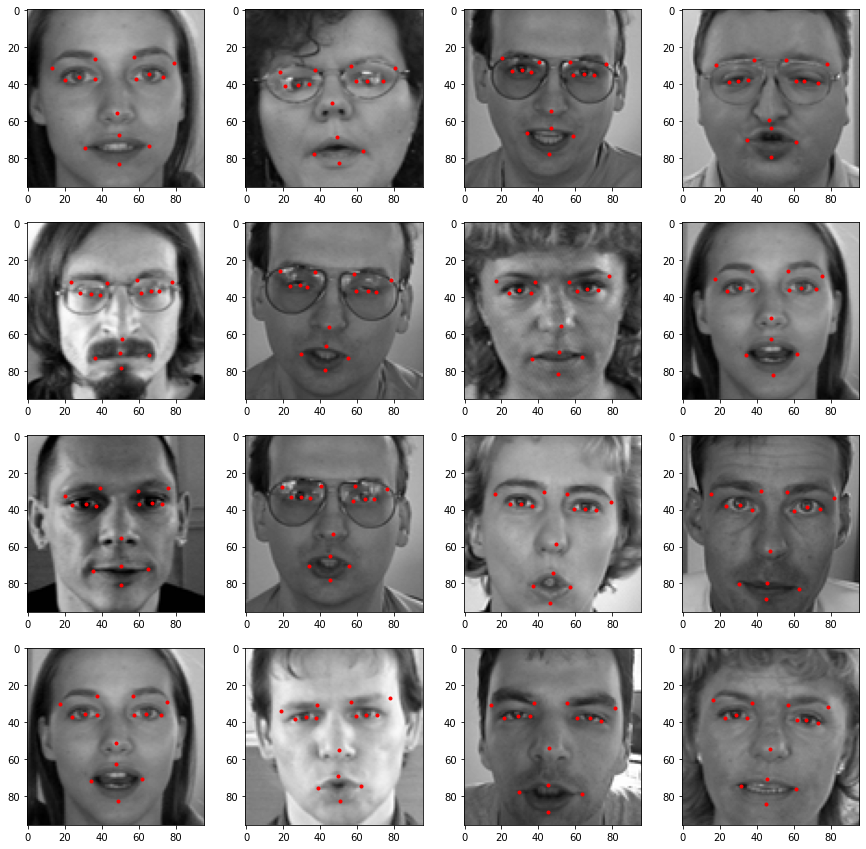

In [40]:
nrows = 4
ncol = 4
fig, ax = plt.subplots(nrows,ncol, figsize=[15,15])

# Random samples
I = (np.random.rand(nrows*ncol) * keypoints_df.shape[0]).astype(int) 

i = 0
for ir in range(n):
    for ic in range(n):
        plt.sca(ax[ir,ic])
        plt.imshow(images_df.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(keypoints_df.iloc[I[i],0::2],
                 keypoints_df.iloc[I[i],1::2],
                 '.r')
        i+=1

In [32]:
keypoints_df.iloc[I[i],1::2]

left_eye_center_y            33.572509
right_eye_center_y           34.742575
left_eye_inner_corner_y      34.742575
left_eye_outer_corner_y      35.132596
right_eye_inner_corner_y     35.132596
right_eye_outer_corner_y     36.302662
left_eyebrow_inner_end_y     22.261702
left_eyebrow_outer_end_y     26.343098
right_eyebrow_inner_end_y    25.771898
right_eyebrow_outer_end_y    29.672204
nose_tip_y                   49.954036
mouth_left_corner_y          74.525673
mouth_right_corner_y         72.965236
mouth_center_top_lip_y       65.945018
mouth_center_bottom_lip_y    81.155782
Name: 172, dtype: float64

In [9]:
A = images_df.iloc[0].item()
np.fromstring(A, sep=' ')

array([238., 236., 237., ...,  70.,  75.,  90.])

In [53]:
np.array([np.float(s) for s in images_df.iloc[0].str.split(' ')[0]])

array([238., 236., 237., ...,  70.,  75.,  90.])

In [48]:
a = images_df.iloc[0].str.split(' ')[0][0]

In [50]:
np.float(a)

238.0

In [54]:
images_df.apply(lambda x: )

SyntaxError: invalid syntax (<ipython-input-54-537279f20969>, line 1)

In [58]:
A = images_df.iloc[0].item()


array([238., 236., 237., ...,  70.,  75.,  90.])